In [ ]:
_ = """
+ CutMix 
+ data_aug

"""

In [ ]:
# traffic sign down
!gdown --id 1-MsSMJqE8AdMQYgS_tiYiaeTkiF4WB5F
!gdown --id 1ysKr2SJAxGWrdSvoA5fn40jhRQmbPswl
!unzip data.zip

In [2]:
!ls

data.zip  sample_data  Test  Test_Label.csv  Train


In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from __future__ import print_function
import argparse
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch.autograd import Variable
import torchvision

import zipfile
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from PIL import Image

import matplotlib.pyplot as plt
nclasses = 43 # GTSRB as 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=1)
        self.conv2 = nn.Conv2d(1, 29, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv3 = nn.Conv2d(29, 59, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv4 = nn.Conv2d(59, 74, kernel_size=3)
        self.maxpool4 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1184, 300)
        self.fc2 = nn.Linear(300, nclasses)
        self.conv0_bn = nn.BatchNorm2d(3)
        self.conv1_bn = nn.BatchNorm2d(1)
        self.conv2_bn = nn.BatchNorm2d(29)
        self.conv3_bn = nn.BatchNorm2d(59)
        self.conv4_bn = nn.BatchNorm2d(74)
        self.dense1_bn = nn.BatchNorm1d(300)
    def forward(self, x):
        x =  F.relu(self.conv1_bn(self.conv1(self.conv0_bn(x))))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3( self.maxpool2(x))))
        x = F.relu(self.conv4_bn(self.conv4( self.maxpool3(x))))
        x = self.maxpool4(x)        
        x = x.view(-1, 1184)
        x = F.relu(self.fc1(x))
        x = self.dense1_bn(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x, -1)

In [4]:
# # https://pytorch.org/docs/stable/notes/randomness.html

# # REPRODUCIBILITY
# # Controlling sources of randomness

# RANDOM_SEED = 0

# torch.manual_seed(RANDOM_SEED)
# torch.cuda.manual_seed_all(RANDOM_SEED)

# random.seed(RANDOM_SEED)
# np.random.seed(RANDOM_SEED)

# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)



# # reduced performance
# # torch.backends.cudnn.deterministic = True # torch.use_deterministic_algorithms(True)
# # torch.backends.cudnn.benchmark = False

# Before starting, clear the memory

torch.cuda.empty_cache()

The proposed MicronNet network was 
- trained for 60,000 iterations 
- in the Caffe framework with 
- a training batch size of 50. 
- Stochastic gradient descent with momentum and exponential decay was utilized as the training policy with 
- the base learning rate set to 0.007,
- the momentum set to 0.9,
- the learning rate decay step size set to 1000,
- and the learning rate decay rate set to 0.9996.
- A l2 weight decay with rate 0.00001 was also used on the
filters and matrices.


In [5]:
epochs = 100
# epochs = 10000
batch_size = 50
seed = 1
log_interval=180
data = "data"
torch.manual_seed(1)
lr =0.007
momentum = 0.9
# step = 1000
step = 50
decay =  0.9996
l2_norm = 0.00001
cuda = True
resume = False
# These may change as described in paper

To balance the number
of samples in different classes as well as improve the generality of the resulting network, a number
of different data augmentation techniques were leveraged including: 
- i) rotation, 
- ii) shifting, 
- iii) sharpening, 
- iv) Gaussian blur, 
- v) motion blur, 
- vi) HSV augmentation, and 
- vii) mirroring. 
As standard
for evaluating performance using GTSRB, 
- all images are cropped and 
- all images are resized to 48×48 pixels

In [6]:


# once the images are loaded, how do we pre-process them before being passed into the network
# by default, we resize the images to 32 x 32 in size
# and normalize them to mean = 0 and standard-deviation = 1 based on statistics collected from
# the training set
data_transforms = transforms.Compose([
    transforms.Resize([48, 48]),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])


In [7]:
# Define path of training data

train_data_path = "./Train"
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)

# Divide data into training and validation (0.8 and 0.2)
ratio = 0.8
n_train_examples = int(len(train_data) * ratio)
n_val_examples = len(train_data) - n_train_examples

train_data, val_data = torch.utils.data.random_split(train_data, [n_train_examples, n_val_examples])

print(f"Number of training samples = {len(train_data)}")
print(f"Number of validation samples = {len(val_data)}")

# Create data loader for training and validation

# DataLoader(
#     train_dataset,
#     batch_size=batch_size,
#     num_workers=num_workers,
#     worker_init_fn=seed_worker
# )

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=False, batch_size = batch_size)

Number of training samples = 20808
Number of validation samples = 5202


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
if  cuda: 
    model.to(device)

if resume :
    state_dict = torch.load("model_28.pth")
    model.load_state_dict(state_dict) 

In [9]:
# https://stackoverflow.com/questions/65318064/can-i-trainoptimize-on-f1-score-loss-with-pytorch
# https://stackoverflow.com/questions/53354176/how-to-use-f-score-as-error-function-to-train-neural-networks
# loss <-- F-Measure as the Error Function to Train Neural Networks 
#

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            # data, target = Variable(data), Variable(target)
            data = data.to(device)
            target =target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        validation_loss /= len(val_loader.dataset)
        print(f"\nValidation set: Average loss: {format(validation_loss, '.4f')}, Accuracy: {correct}/{len(val_loader.dataset)} ({format(100. * correct / len(val_loader.dataset), '.0f')}%)\n")
    return validation_loss


def train(epoch , train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = Variable(data), Variable(target)
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target).cuda()
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch}\t[{batch_idx * len(data)}/{len(train_loader.dataset)}\t({format(100. * batch_idx / len(train_loader),'.0f')}%)]\tLoss: {format(loss.item(),'.6f')}")

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr , momentum=momentum, weight_decay=l2_norm, nesterov=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)

temp = 10
epochs = 20
for epoch in range(1, epochs):
    train(epoch, train_loader)
    val = validation()
    if epoch % step == 0 :
        scheduler.step()
    if val < temp : 
        temp = val
        model_file = 'model_' + str(epoch) + '.pth'
        torch.save(model.state_dict(), model_file)
        print('\nSaved model to ' + model_file + '. You can run `python evaluate.py ' + model_file + '` to generate the Kaggle formatted csv file')


In [11]:
# Print confusion matrix

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (20, 20));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    
labels_arr = range(0, nclasses)
# plot_confusion_matrix(labels_list, y_pred_list, labels_arr)


In [12]:
# # Load the saved model

# model = Net()
# model.load_state_dict(torch.load(model_file)) # 'model_35.pth'
# model = model.cuda()

# # model = Net()
# # model.load_state_dict(torch.load('model_35.pth')) # 'model_35.pth'
# # model = model.cuda()

In [99]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file
                                    #   , names=['Filename', 'ClassId']
                                      )
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

num = range(nclasses)
torch_class_to_real_class = [str(i) for i in num]
torch_class_to_real_class = sorted(torch_class_to_real_class)
torch_class_to_real_class = [int(torch_class_to_real_class[i]) for i in num]

def evaluate_test(model, loader, torch_class_to_real_class):
    model.eval()
    y_true_list = []
    y_pred_list_before_mapping = []
    with torch.no_grad():
        for (images, labels) in test_dataloader:
            y_true_list.append(labels)
            images = images.cuda()

            output = model(images)
            
            y_pred_tags = output.data.max(1, keepdim=True)[1]
            y_pred_tags = y_pred_tags.cpu().numpy().reshape(-1)
            y_pred_list_before_mapping.append(y_pred_tags)

    
    y_true_list = np.concatenate(y_true_list)
    total_y_pred_list_before_mapping = np.concatenate(y_pred_list_before_mapping)
    y_pred_list = [torch_class_to_real_class[torch_class] for torch_class in total_y_pred_list_before_mapping]

    macro_f1 = f1_score(
        y_true = y_true_list,
        y_pred = y_pred_list,
        average = 'macro')
    
    return macro_f1, y_pred_list

In [100]:
ans_file_name = "Test_Label.csv"
img_dir = "Test"
test_transform = transforms.Compose([
    transforms.Resize([48, 48]),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629)) # need to change mean / std 
])
test_batch_size = 1_000

test_data = CustomImageDataset(ans_file_name, img_dir, test_transform)
test_dataloader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size = test_batch_size)

In [101]:
model_name_to_macro_f1 = {}

best_model_name_list = []
best_macro_f1 = 0
best_pred_list = []

for model_name in os.listdir():
    if model_name.startswith("model_") and model_name.endswith(".pth"):
        model = Net()
        model.load_state_dict(torch.load(model_name)) # 'model_35.pth'
        model = model.cuda()

        curr_score, curr_y_pred_list = evaluate_test(model, test_dataloader, torch_class_to_real_class)
        model_name_to_macro_f1[model_name] = curr_score

        if curr_score > best_macro_f1:
            best_model_name_list = [model_name]
            best_macro_f1 = curr_score
            best_pred_list = curr_y_pred_list

        elif curr_score == best_macro_f1:
            best_model_name_list.append(model_name)
print(f"""
Best Score\t=\t{best_macro_f1}
best_model_name_list\t=\t{best_model_name_list}
""")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning:


Best Score	=	0.9539183758384255
best_model_name_list	=	['model_16.pth']



In [ ]:
model = Net()
model.load_state_dict(torch.load(best_model_name_list[0])) # 'model_35.pth'
model = model.cuda()

y_pred_list = []
# test model perf.
with torch.no_grad():
    model.eval()
    for f_name in test_answer["Filename"]:
        image = Image.open(f"Test//{f_name}")

        image = test_transforms(image)
        image = torch.unsqueeze(image, 0)
        image = image.to(device)

        y_test_pred = model(image)
        y_pred_tags = y_test_pred.data.max(1, keepdim=True)[1]
        y_pred_tags = y_pred_tags.cpu().numpy()

        y_pred = y_pred_tags[0][0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

curr_score = f1_score(
    y_true = test_answer.ClassId,
    y_pred = y_pred_list,
    average = 'macro'
    )
# model_name_to_macro_f1[model_name] = curr_score

In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
if  cuda: 
    model.to(device)

if resume :
    state_dict = torch.load("model_28.pth")
    model.load_state_dict(state_dict) 

In [ ]:
# Define path of training data

train_data_path = "./Train"
train_all_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = data_transforms)
train_all_loader = torch.utils.data.DataLoader(train_all_data, shuffle=True, batch_size = batch_size)

optimizer = torch.optim.SGD(model.parameters(), lr=lr , momentum=momentum, weight_decay=l2_norm, nesterov=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)

epochs_for_all = 30
for epoch in range(1, epochs_for_all):
    train(epoch, train_all_loader)
    if epoch % step :
        print(epoch)
        scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.





1



2



3



4



5



6



7



8



9



10



11



12



13



14



15



16



17



18



19



20



21



22



23



24



25



26



27



28



29


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Number of correctly classified images = 8453
Number of incorrectly classified images = 217
Final accuracy = 0.974971
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.95      1.00      0.98       420
           2       0.99      1.00      0.99       420
           3       0.99      0.97      0.98       420
           4       1.00      1.00      1.00       420
           5       0.92      0.98      0.95       420
           6       1.00      0.73      0.85        60
           7       0.98      0.99      0.98       420
           8       0.98      1.00      0.99       420
           9       0.97      1.00      0.98       420
          10       1.00      0.99      0.99       420
          11       0.95      0.99      0.97       420
          12       0.99      0.99      0.99       420
          13       0.99      1.00      0.99       420
          14       1.00      1.00      1.00       210
          15      

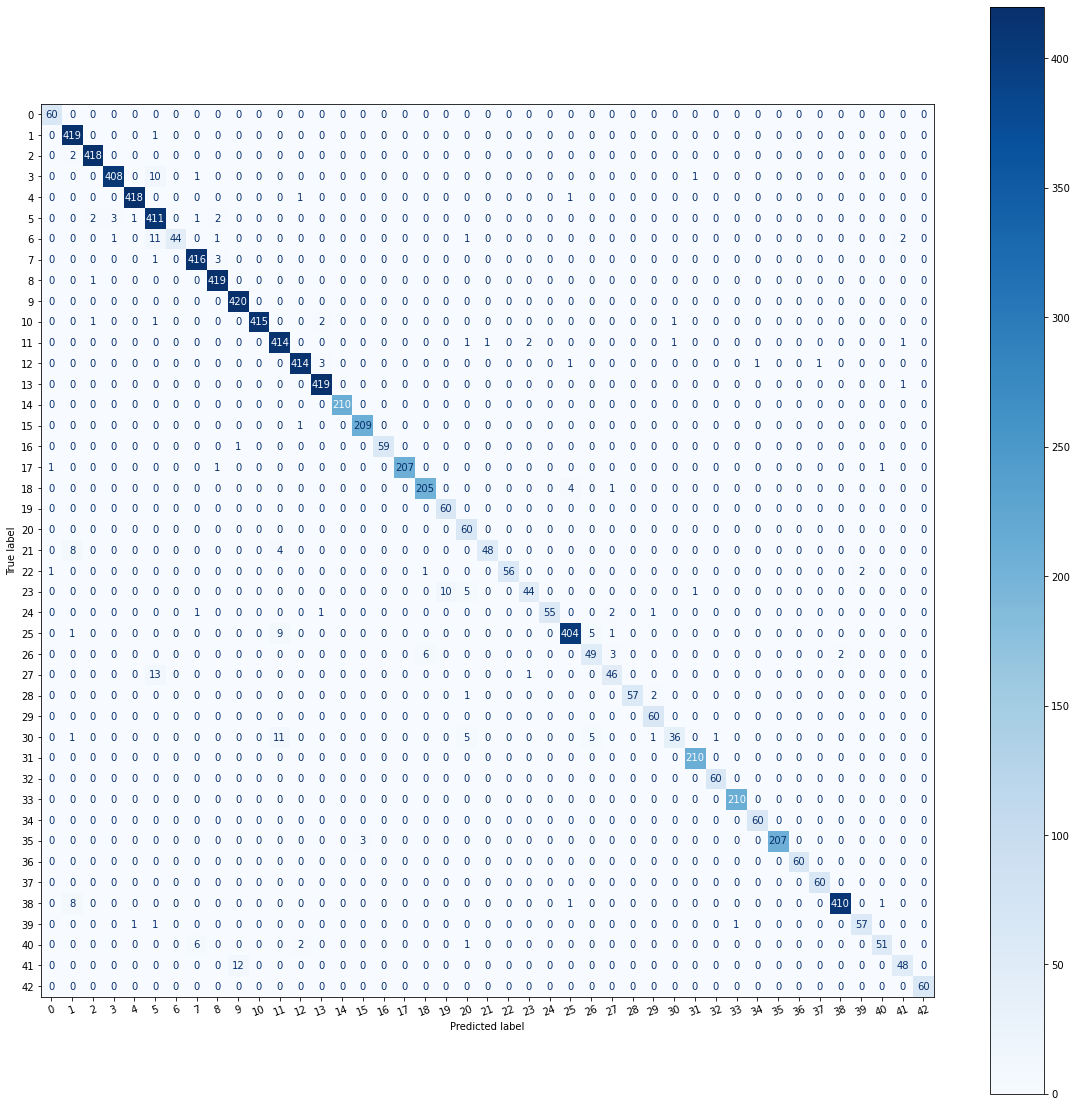

In [ ]:
test_answer = pd.read_csv('Test_Label.csv')
test_answer["pred_class"] = -1

num = range(nclasses)
labels = []
for i in num:
    labels.append(str(i))
labels = sorted(labels)
for i in num:
    labels[i] = int(labels[i])


test_transforms = transforms.Compose([
    transforms.Resize([48, 48]),
    transforms.ToTensor(),
    transforms.Normalize((0.3337, 0.3064, 0.3171), ( 0.2672, 0.2564, 0.2629))
])


# Perform classification

y_pred_list = []
corr_classified = 0
numExamples = len(test_answer)

##
labels_list = []



with torch.no_grad():
    model.eval()
    for f_name in test_answer["Filename"]:
        image = Image.open(f"Test//{f_name}")

        image = test_transforms(image)
        image = torch.unsqueeze(image, 0)
        image = Variable(image)
        image = image.to(device)

        y_test_pred = model(image)
        y_pred_tags = y_test_pred.data.max(1, keepdim=True)[1]
        y_pred_tags = y_pred_tags.cpu().numpy()
        # print(y_pred_tags)

        y_pred = y_pred_tags[0][0]
        y_pred = labels[y_pred]
        
        y_pred_list.append(y_pred)

        # test_answer.loc[test_answer[test_answer["Filename"] == f_name].index, "pred_class"] = y_pred
        if test_answer[test_answer["Filename"] == f_name]["ClassId"].values[0] == y_pred:
            corr_classified += 1

        # i += 1

print("Number of correctly classified images = %d" % corr_classified)
print("Number of incorrectly classified images = %d" % (numExamples - corr_classified))
print("Final accuracy = %f" % (corr_classified / numExamples))

# Print classification report
print(classification_report(test_answer.ClassId, y_pred_list))

plot_confusion_matrix(test_answer.ClassId, y_pred_list, labels_arr)